In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.sparse
import json
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('PP_recipes.csv')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## functior to visualize a saprse scipi matrix
def spy(A, figsize=(4, 100), markersize=0.1):
    """Visualizes a sparse matrix."""
    fig = plt.figure(figsize=figsize)
    plt.spy(A, markersize=markersize)
    plt.show()

In [4]:
def get_our_U_rec():
    '''
    return the Rec ids of the user with the max number of recpies
    '''
    
    user = pd.read_csv('PP_users.csv')
    #maxx = user['n_items'].max()
    #our_U  = user[user['n_items']==maxx]
    user_ids = [2203, 2605, 1372, 1908, 5248, 3179, 1013, 989, 5423, 135, 6267, 7547]
    our_U  = user[user['u'].isin(user_ids)]
    
    rec_ids = []
    for i in range(our_U.shape[0]):
        rec_ids+= json.loads(our_U.iloc[i,:]['items'])
 
    return list(set(rec_ids))

In [5]:
rec = get_our_U_rec()
len(rec)

1773

In [6]:
def get_rec_dict(df):
    '''
    takes rec_df and returns dict mapping recipie to ingr list
    '''
    cols_keep = ['id', 'ingredient_ids']
    rec = df[cols_keep].set_index('id')
    rec_dict = rec['ingredient_ids'].to_dict()
    
    return {k:list(set(json.loads(v))) for k,v in rec_dict.items()}

In [7]:
def get_unique_ing(rec_dict):
    '''
    takes rec_dict and returns list of unique recpies
    '''
    ing_list = []
    for _ ,ing in rec_dict.items():
        ing_list += ing
    
    return list(set(ing_list))

In [8]:
def ing2id(ings):
    '''
    takes ingriedient list and returns a dict that maps ingredient ids to index
    '''
    return {v:i for i,v in enumerate(ings) }

In [9]:
def id2ing(ings):
    '''
    takes ingriedient list and returns a dict that maps ingredient ids to index
    '''
    return {i:v for i,v in enumerate(ings) }

In [10]:
def id2rec(df):
    '''
    takes ingriedient list and returns a dict that maps ingredient indec to ingr_id
    '''
    return df['id'].to_dict()

In [11]:
def rec2id(df):
    '''
    takes ingriedient list and returns a dict that maps ingredient ids to index
    '''
    id2rec = df['id'].to_dict()
    return {v:k for k,v in id2rec.items() }

In [12]:
def comp_jaccard_sim(M, i):
    '''
    takes sparse matrix of rec and ingr, and takes input recpie index
    returns all recpies that are >=50% similar to input recepie
    '''
    THRESH = 0.50
    
    intrsection = np.sum(M[i].multiply(M), axis=1).reshape(1,M.shape[0])

    repeated_row_matrix = sp.sparse.csr_matrix(np.ones([M.shape[0],1])) * M[i]
    add = repeated_row_matrix+M
    add[add > 0] = 1
    union = np.sum(add, axis=1).reshape(1,M.shape[0])
    
    jaccard_sim = intrsection/union
    jaccard_sim[:,i] = 0
    jaccard_sim = np.asarray(jaccard_sim).reshape(-1)
    
    sorted_sim = -np.sort(-jaccard_sim)
    arg_sorted_sim = np.argsort(-jaccard_sim)
    
    index = np.argwhere(sorted_sim >= THRESH).reshape(-1)
    
    cutoff = 0
    if len(index) > 0:
        cutoff = np.max(index)
   
   
    return sorted_sim[:min(cutoff,50)] , arg_sorted_sim[:min(cutoff,50)]
    #return sorted_sim[:50], arg_sorted_sim[:50]


In [13]:
rec_dict = get_rec_dict(df)
rec2id_dict = rec2id(df)

ings =  get_unique_ing(rec_dict)
ing2id_dict = ing2id(ings)
id2ing_dict = id2ing(ings)

id2dff = id2rec(df)

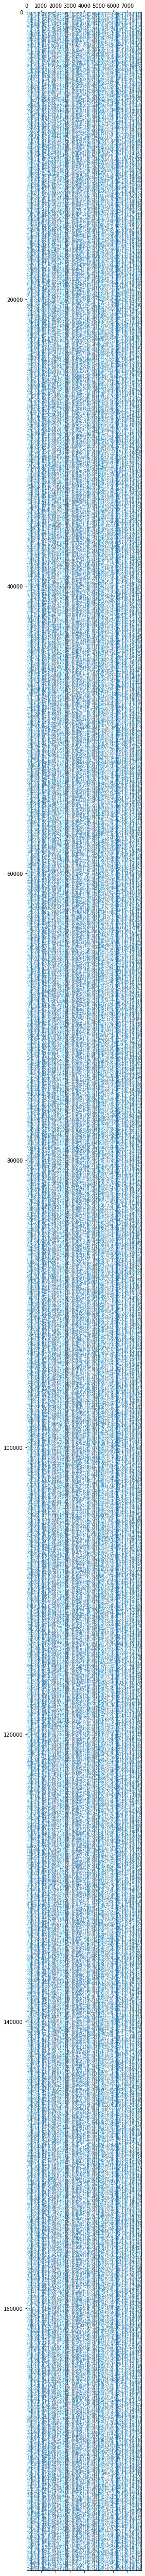

In [14]:
### build sparse csr matrix
rows = []
cols = []


for rec, ing_l in rec_dict.items():
    for ing in ing_l:
        rows.append(rec2id_dict[rec])
        cols.append(ing2id_dict[ing])

vals = [1]*len(rows)

P = sp.sparse.csr_matrix((vals,
                          (rows, cols)),
                         shape=(np.max(rows)+1, np.max(cols)+1), dtype=float)
spy(P)

In [15]:
comp_jaccard_sim(P, rec2id_dict[41056])

(array([0.88888889, 0.875     , 0.875     , 0.77777778, 0.77777778,
        0.77777778, 0.77777778, 0.72727273, 0.7       , 0.7       ,
        0.7       , 0.7       , 0.7       , 0.7       , 0.7       ,
        0.7       , 0.7       , 0.7       , 0.7       , 0.66666667,
        0.66666667, 0.66666667, 0.66666667, 0.63636364, 0.63636364,
        0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
        0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
        0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
        0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
        0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.625     ]),
 array([165804,  34367, 167320, 153039,  18519,   7244, 128218, 102200,
         67325, 164608,  71382,   1591,  93949,  73120,  37271, 162386,
         24887, 108986,  99886, 107020, 101780, 174618, 111032,  33784,
         65677, 173364,  26398,   5856,  95746,  55529, 138939,  96939,
        119162,   2338, 129169

In [16]:
%%time
dd = {}
ss = {}

f = lambda x: id2dff[x] 
mapper  = np.vectorize(f)

for i in get_our_U_rec():
    if i in rec2id_dict.keys():
        A,B = comp_jaccard_sim(P, rec2id_dict[i])
        if len(A)>0 and len(B>0):
            dd[i] = A
            ss[i] = mapper(B)

Wall time: 3min 8s


In [17]:
%%time
r_id = []
s_r_id = []
sim = []
for recid,sim_r_list in ss.items():
    for i,s_recid in enumerate(sim_r_list):
        r_id.append(recid)
        s_r_id.append(s_recid)
        sim.append(dd[recid][i])
        

Wall time: 4.03 ms


In [18]:
len(r_id)

7029

In [20]:
%%time
data_tuples = list(zip(r_id,s_r_id,sim))
sim_df = pd.DataFrame(data_tuples, columns=['rec_id','sim_rec_id','similarity'])

Wall time: 53.6 ms


In [21]:
#sim_df.to_csv('rec_sim.csv')

In [22]:
sim_df

,rec_id,sim_rec_id,similarity
0,155665,44575,0.777778
1,155665,483691,0.666667
2,155665,228900,0.666667
3,155665,124330,0.666667
4,155665,104248,0.625000
...,...,...,...
7024,57336,413859,0.583333
7025,57336,287987,0.583333
7026,57336,28995,0.583333
7027,57336,306075,0.583333


# END